# Topic modelling & Caddy performance evaluation

A note book to evaluate the messages recieved previously, categorise into topics and judge approval rate of those messages

Looking for an output that shows performance across various topics as well as demand to support with corpus scraping and maintenance

Steps:
1) Locate data of historical messages / responses in download from s3
2) Use topic modelling to categorise the message / responses
3) Look at the approval rate of the messages 

Import all libraries

In [41]:
import boto3
import os
import pandas as pd
import re
from bs4 import BeautifulSoup
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt


/Users/max.hollingdale/Library/Caches/pypoetry/virtualenvs/caddy-chatbot-B-atQbAG-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 1: Ingest data

In [7]:
session = boto3.Session()
credentials = session.get_credentials()

# === Database Connections ===
dynamodb = boto3.resource("dynamodb", region_name="eu-west-2")

# === Tables ===
responses_table = dynamodb.Table("caddyResponses-prod")

responses_data = responses_table.scan()['Items']


Step 1a: Clean data

In [12]:
df_responses = pd.DataFrame(responses_data)
df_responses['Office'] = df_responses.apply(lambda x: str(x['approverEmail']).split('@')[-1], axis=1)

In [37]:
def clean_and_extract_urls(llm_response):

    # Step 1: Remove the <font> tag and its attributes
    cleaned_text = re.sub(r'<font[^>]*>', '', llm_response)
    cleaned_text = re.sub(r'</font>', '', cleaned_text)

    # Step 2: Extract and remove URLs
    urls = re.findall(r'<ref>(.*?)</ref>', cleaned_text)
    cleaned_text = re.sub(r'<ref>(.*?)</ref>', '', cleaned_text)

    # Step 3: Further cleaning (remove remaining HTML tags, line breaks, etc.)
    cleaned_text = re.sub(r'<[^>]+>', '', cleaned_text)  # Remove any other HTML tags
    cleaned_text = cleaned_text.replace('\\n', ' ').strip()  # Replace \n with space and strip leading/trailing spaces

    return cleaned_text, urls

df_responses[['cleaned_text', 'urls']] = df_responses['llmAnswer'].apply(lambda x: pd.Series(clean_and_extract_urls(x)))




Now we have:
- cleaned text which is the response from each llm
- urls which is the rag documents returned
- office which is the office of the individual messaging from
- llmprompt which is the user query

Step 2: Topic modelling

Use bertopic as that is what consult ahve used and can ask them questions

Pros:
Works well with short texts.
No need to specify the number of topics in advance.
Can use pre-trained language models for embeddings.

Cons:
Requires more computational resources.
More complex to set up compared to traditional methods.

Seeding approach

In [52]:

seed_topic_list = [
    ["finance", "debt", "support", "benefits", "universal", "charity"],
    ["tax", "threshold", "guidance", "council"],
    ["immigration", "visa", "asylum", "UK"],
    ["housing", "rent", "landlord"],
    ["health", "nhs", "care"],
    ["violence", "abuse", "controlling", "family","children", "partner"],
    # ... add more seed topics
]

# Initialize the sentence transformer model
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Create embeddings
embeddings = sentence_model.encode(df_responses['cleaned_text'].tolist(), show_progress_bar=True)

model = BERTopic(language="english", seed_topic_list=seed_topic_list)
topics, probabilities = model.fit_transform(df_responses['cleaned_text'], embeddings=embeddings)

# Display topics
print(model.get_topic_info())

Batches: 100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


   Topic  Count                      Name  \
0     -1     37         -1_the_to_if_your   
1      0     34  0_the_universal_your_for   
2      1     33      1_the_to_landlord_if   
3      2     18         2_the_pip_to_your   
4      3     14          3_to_the_uk_your   
5      4     14        4_the_to_client_if   

                                      Representation  \
0  [the, to, if, your, you, for, client, and, or,...   
1  [the, universal, your, for, to, you, credit, i...   
2  [the, to, landlord, if, your, notice, client, ...   
3  [the, pip, to, your, if, for, they, and, clien...   
4  [to, the, uk, your, if, they, for, in, child, ...   
5  [the, to, client, if, your, and, complaint, se...   

                                 Representative_Docs  
0  [TL;DR Your client may be able to get help fro...  
1  [Brief Summary: Your client's Universal Credit...  
2  [Brief Summary: To determine if the section 21...  
3  [TL;DR: Your client may be able to get their E...  
4  [Based on the

Scatterplot of embeddings, want to show spread

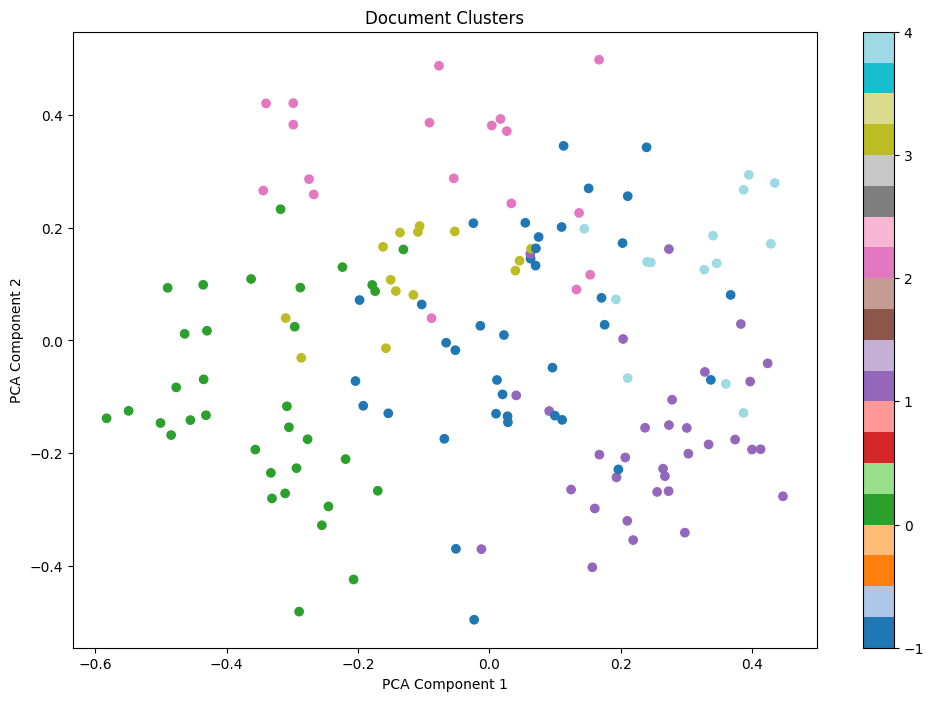

In [69]:
from sklearn.decomposition import PCA

# Reduce embeddings to 2D
pca = PCA(n_components=2)
doc_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(doc_2d[:, 0], doc_2d[:, 1], c=topics, cmap='tab20')
plt.colorbar(scatter)
plt.title('Document Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

Word cloud

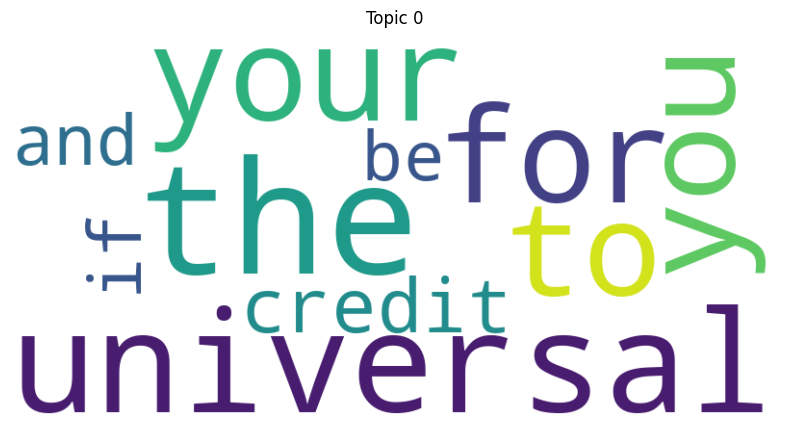

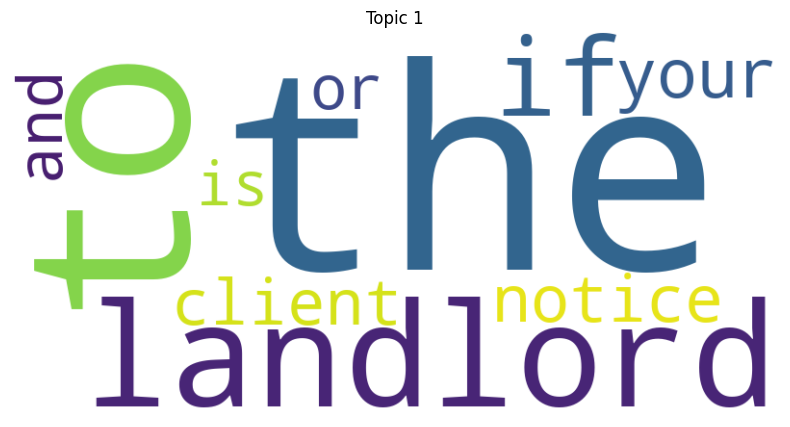

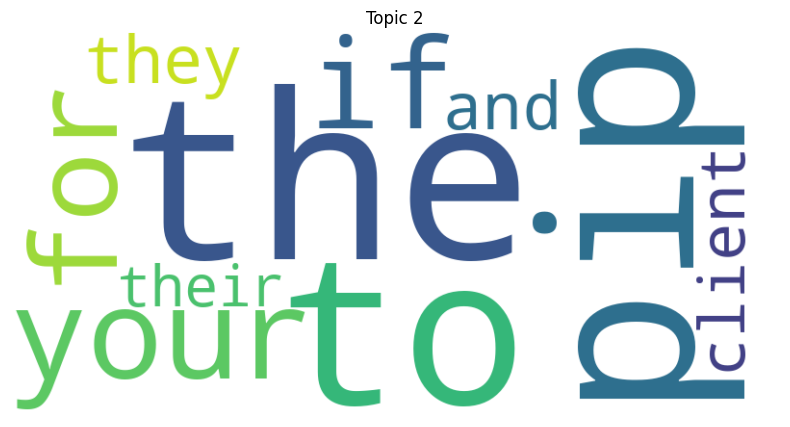

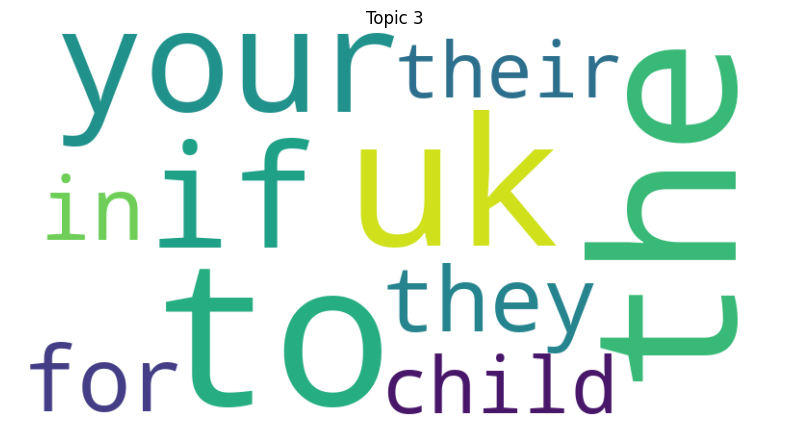

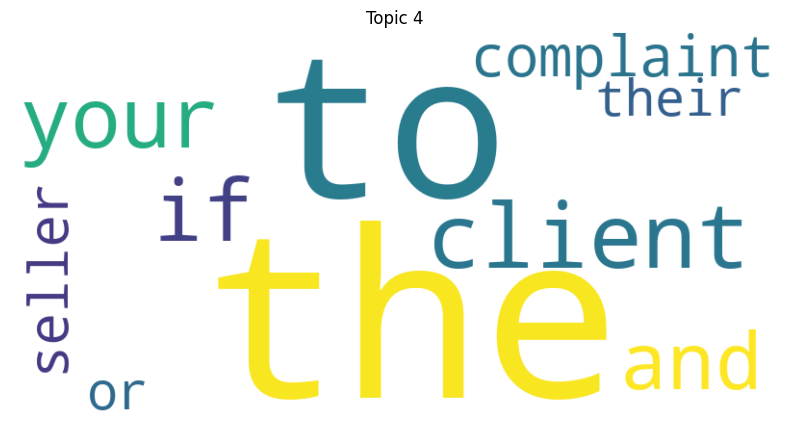

In [72]:
from wordcloud import WordCloud

def plot_word_cloud(topic):
    words = dict(model.get_topic(topic))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic}')
    plt.show()

# Plot word cloud for each topic
for topic in set(topics):
    if topic != -1:  # -1 is often used for outliers
        plot_word_cloud(topic)

In [86]:
custom_labels = {
    '-1': "Outliers",
    '0': "Universal Credit",
    '1': "Housing",
    '2': "Disability & PIP",
    '3': "Immigration",
    '4': "Consumer goods and services"
}


In [84]:
# Add the topics to the dataframe
df_responses['Topic'] = topics

# Get the topic labels
topic_info = model.get_topic_info()
topic_labels = {row['Topic']: row['Name'] for _, row in topic_info.iterrows()}

# Add the topic labels to the dataframe
df_responses['Topic_Label'] = df_responses['Topic'].map(topic_labels)


In [89]:
df_responses['Custom topics'] = df_responses['Topic'].map(custom_labels)

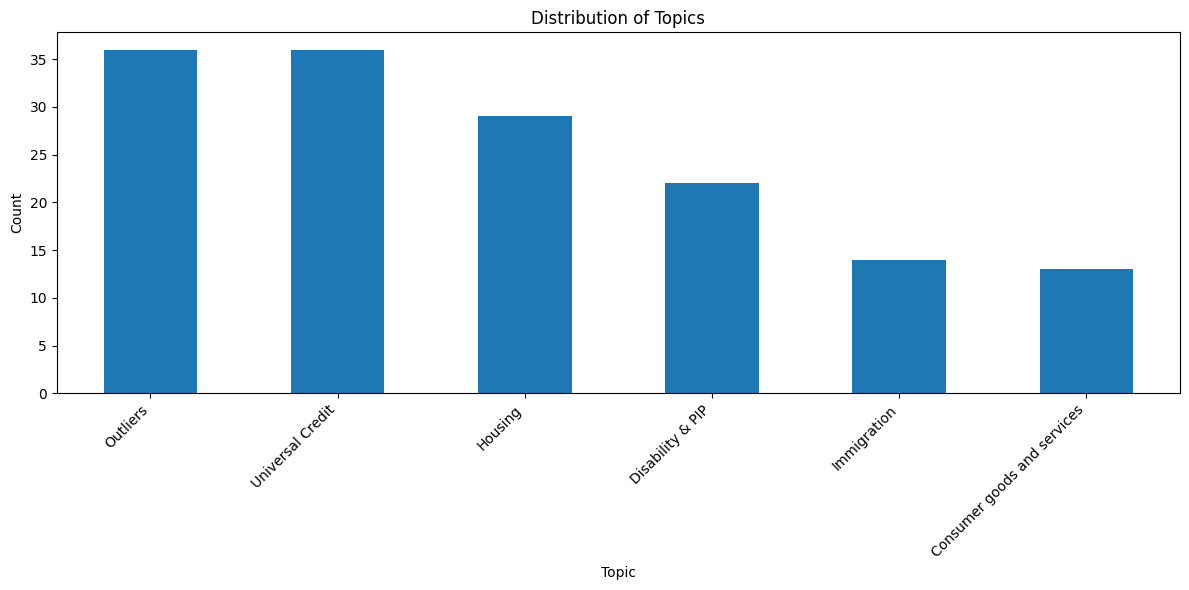

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_responses['Custom topics'].value_counts().plot(kind='bar')
plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Step 3: Look at approval rate of topics

In [93]:
df_responses.columns

Index(['approvalTimestamp', 'approverEmail', 'approverReceivedTimestamp',
       'llmResponseTimestamp', 'userThankedTimestamp', 'approved',
       'llmPromptTimestamp', 'messageId', 'llmAnswer', 'supervisorMessage',
       'llmResponseJSon', 'responseId', 'llmPrompt', 'threadId',
       'userResponseTimestamp', 'Office', 'cleaned_text', 'urls', 'Topic',
       'Topic_Label', 'Custom topics'],
      dtype='object')

In [94]:
df_responses_approved = df_responses[['approved','Office','Custom topics']].groupby(by='approved', axis=1)

In [65]:
df_responses_approved

In [95]:


# Create a cross-tabulation of Topic_Label and another relevant column
# For example, if you have an 'Office' column:
cross_tab = pd.crosstab(df_responses['Custom topic'], df_responses['Office'])

# If you don't have an 'Office' column, you can use any other relevant categorical column
# Or, if you want to see co-occurrence of topics:
# cross_tab = pd.crosstab(df_responses['Topic_Label'], df_responses['Topic_Label'])

# Normalize the cross-tabulation
cross_tab_normalized = cross_tab.div(cross_tab.sum(axis=1), axis=0)

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cross_tab_normalized, annot=True, cmap='YlOrBr', fmt='.2f')
plt.title('Topic Distribution Heatmap')
plt.ylabel('Topic')
plt.xlabel('Office')  # Change this if you're using a different column
plt.tight_layout()
plt.show()

KeyError: 'Custom topic'

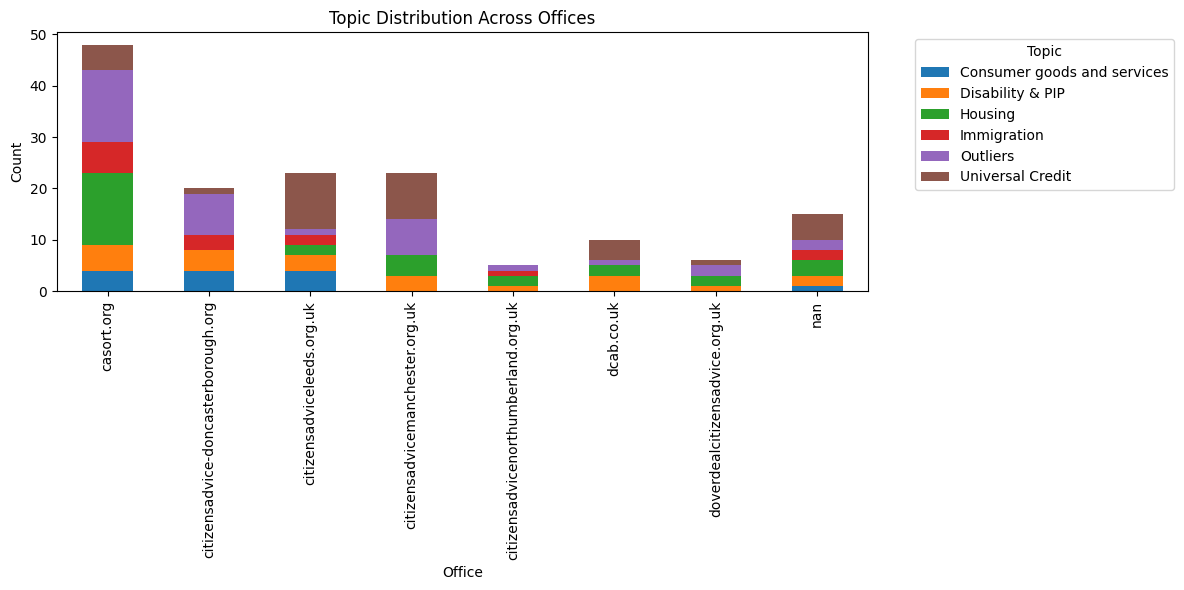

In [97]:
import pandas as pd

# Create a cross-tabulation of Office and Topic_Label
cross_tab = pd.crosstab(df_responses['Office'], df_responses['Custom topics'])

# Create a stacked bar chart
cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Topic Distribution Across Offices')
plt.xlabel('Office')
plt.ylabel('Count')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

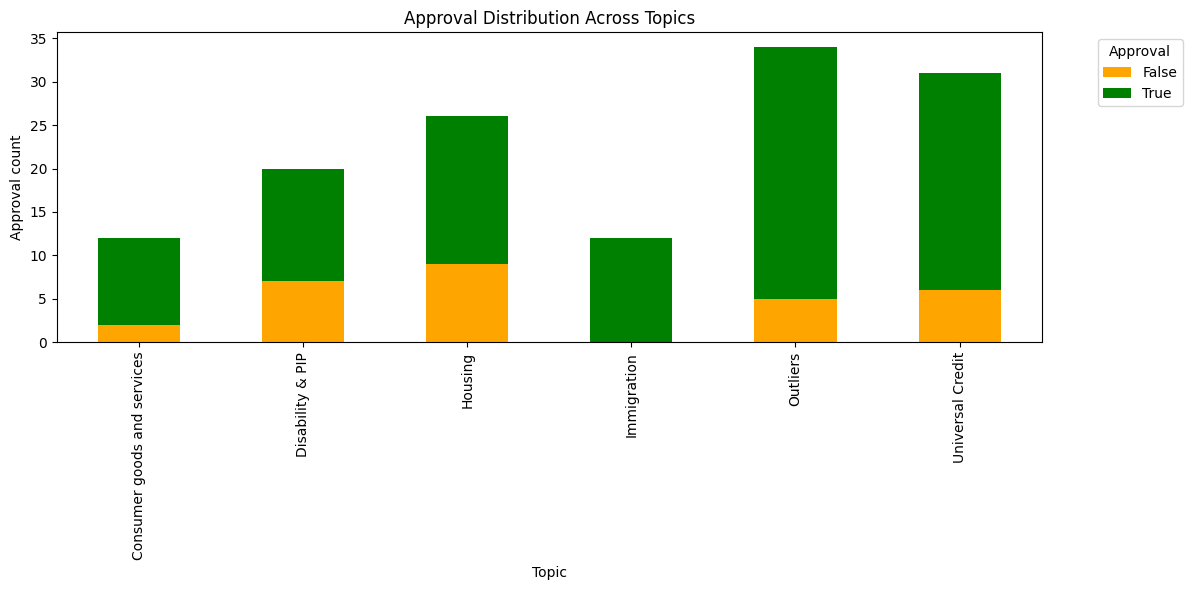

In [108]:
import pandas as pd

# Create a cross-tabulation of Office and Topic_Label
cross_tab = pd.crosstab(df_responses['Custom topics'], df_responses['approved'])

# Define colors for the bars based on exact column names
color_map = {
    True: 'green',  # Adjust these if your column names are not exactly `True`/`False`
    False: 'orange'
}

# Create a list of colors corresponding to each column in cross_tab
colors = [color_map.get(col, 'gray') for col in cross_tab.columns]

# Create a stacked bar chart
cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)
plt.title('Approval Distribution Across Topics')
plt.xlabel('Topic')
plt.ylabel('Approval count')
plt.legend(title='Approval', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()